In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [3]:
import statsmodels.api as sm 
import pylab as py

In [4]:
import nibabel as nib
import random

For a given couple of pipeline, we have 1000 group analyses. The function **voxel_concat** takes as input the parameter values for the first and the second pipeline, stores all the statistical values contained within the mask in a list for each of the 1000 group analyses, and returns a concatenation of the 1000 lists obtained.

Since the resulting list of voxels obtained is very large (more than 150M statistical values) and using it for further observations can be very time-consuming, we only take a random sample of 1M values. The function **save_sample** takes a vector and a file name as input and stores a random sample (fixed with a seed) within a .txt file.

To avoid having to execute *voxel_concat* (which can take a long time) each time we need to extract the sample values, and thus simplify the re-execution of the notebook, we will use a function **voxel_concat_sample**, which takes as input parameter values for both pipelines, uses *voxel_concat* and *save_sample* as auxiliary functions to create the random sample file only if it does not exists already, and reads and returns the file content when the file exists.

In [5]:
def voxel_concat(smooth1,reg1,der1,smooth2,reg2,der2):
    Vect_vox=[]
    smooth1=str(smooth1)
    smooth2=str(smooth2)
    reg1=str(reg1)
    reg2=str(reg2)
    der1=str(der1)
    der2=str(der2)
    for i in range(1000):
        fold='SLA'+str(i+1)+'_50_hand'
        V0 = nib.load(os.path.join('..', 'data',fold,'smooth_'+smooth1+'_'+smooth2,'reg_'+reg1+'_'+reg2,'der_'+der1+'_'+der2,'spmT_0001.nii.gz')).get_data().flatten()
        V1 = nib.load(os.path.join('..', 'data',fold,'smooth_'+smooth1+'_'+smooth2,'reg_'+reg1+'_'+reg2,'der_'+der1+'_'+der2,'mask.nii.gz')).get_data().flatten()
        V0bis=V0[V1!=0].tolist()
        Vect_vox=Vect_vox+V0bis
    return Vect_vox;

In [6]:
def save_sample(data,name):
    random.seed(0)
    data_sample=random.sample(data,1000000)
    
    sample_file = open(name+".txt","w")
    for i in range(1000000):
        sample_file.write(str(data_sample[i]))
        if i!=999999:
            sample_file.write(" \n")
    sample_file.close()

In [7]:
def voxel_concat_sample(smooth1,reg1,der1,smooth2,reg2,der2):
    
    if not(os.path.isfile('sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'.txt')):
        vect_vox1 = voxel_concat(smooth1,reg1,der1,smooth2,reg2,der2)
        save_sample(vect_vox1,'sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2))
        
    with open('sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'.txt',"r") as V0:
        filecontents=V0.readlines()
    Vect_vox_sample=[float(i) for i in filecontents]
    return Vect_vox_sample;

We created various functions to compare the distributions obtained with the expected distribution for a student law with df=98. We have **qqplot_stat**, which creates a classical Q-Q plot between the statistical values obtained and the expected quantiles ; **qqplot_pval**, which does the same but with the p-values $1-F(x_i)$ instead of the $x_i$.

We also created a **Bland_Altman** function to do Bland-Altman plots giving the difference between the observed and expected p-values for each expected p-values. Two other functions, **Bland_Altman_log1** and **Bland_Altman_log2** do the same thing but with $log_{10}(p)$ and $-log_{10}(1-p)$ instead of $p$, with p being the expected and observed p-values.

In [8]:
def qqplot_stat(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')

    p_th = [dist.ppf(t/len(data),98) for t in range(1,len(data)+1)]
    line1, = ax2.plot(p_th, sorted(np.array(data)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [9]:
def qqplot_pval(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    ax1.set_title('Distribution of the Statistical Values')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]

    p_th_sub=[1000*t/len(data) for t in range(1,(len(data)+1)//1000)]
    
    conf_int_inf = [1-beta.interval(0.95,len(data)-i*1000,1+i*1000,loc=0,scale=1)[0] for i in range(1,(len(data)+1)//1000)]
    conf_int_sup = [1-beta.interval(0.95,len(data)-i*1000,1+i*1000,loc=0,scale=1)[1] for i in range(1,(len(data)+1)//1000)]
    line1, = ax2.plot(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.fill_between(p_th_sub,conf_int_inf,conf_int_sup,color="lightgrey")
    ax2.set_title('Q-Q plot')
    ax2.set_xlabel('expected p-values')
    ax2.set_ylabel('observed p-values')
    plt.show()

In [10]:
def qqplot_pval_conf(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]
    conf_int_inf = [1-beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[0] for i in range(1,len(data)+1)]
    conf_int_sup = [1-beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[1] for i in range(1,len(data)+1)]
    line1, = ax2.plot(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.plot(p_th, conf_int_inf, '-')
    ax2.plot(p_th, conf_int_sup, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [11]:
def qqplot_pval_log1(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.loglog(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.loglog(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [12]:
def qqplot_pval_log1_conf(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.loglog(p_th, sorted(dist.sf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.loglog(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [13]:
def qqplot_pval_log2(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.loglog(p_th, sorted(dist.cdf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.loglog(p_th, p_th, '-')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    ax2.set_title('Q-Q plot')
    plt.show()

In [14]:
def qqplot_pval_log2_conf(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')
    
    beta=scipy.stats.beta
    p_th = [t/len(data) for t in range(1,len(data)+1)]
    line1, = ax2.loglog(p_th, sorted(dist.cdf(np.array(data),98)), '.', linewidth=1,
                         label='Q-Q plot')
    ax2.loglog(p_th, p_th, '-')
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    ax2.set_title('Q-Q plot')
    plt.show()

In [15]:
def qqplot_frac(data,num_bins):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    n, bins, patches = ax1.hist(np.array(data),num_bins,density=True)
    dist = scipy.stats.t
    y=dist.pdf(bins,98)
    ax1.plot(bins, y, '-')

    p_th = [t/len(data) for t in range(1,len(data)+1)]
    p_obs_sort = sorted(dist.sf(np.array(data),98))
    
    k=0
    p_obs_2 = []
    for i in range(len(data)):
        while k < len(data) and p_obs_sort[k] < p_th[i]:
            k=k+1
        p_obs_2=p_obs_2+[(len(data)-k)/len(data)]
    p_obs_2=sorted(p_obs_2)
        
    
    line1, = ax2.plot(p_th, p_obs_2, '.', linewidth=1,
                         label='Q-Q plot')
    ax2.plot(p_th, p_th, '-')
    ax2.set_title('Q-Q plot')
    plt.show()

In [16]:
def Bland_Altman(data):
    f,(ax2) = plt.subplots(1,sharey=False,figsize=(10,5))

    dist = scipy.stats.t
    beta = scipy.stats.beta

    p_th = [t/len(data) for t in range(1,len(data)+1)]
    p_obs = sorted(dist.sf(np.array(data),98))
    
    ba_diff = [(p_obs[i] - p_th[i]) for i in range(len(data))]
    
    p_th_sub=[1000*t/len(data) for t in range(1,(len(data)+1)//1000)]
    
    conf_int_inf = [1-beta.interval(0.95,len(data)-i*1000,1+i*1000,loc=0,scale=1)[0]-1000*i/len(data) for i in range(1,(len(data)+1)//1000)]
    conf_int_sup = [1-beta.interval(0.95,len(data)-i*1000,1+i*1000,loc=0,scale=1)[1]-1000*i/len(data) for i in range(1,(len(data)+1)//1000)]
        
    line1, = ax2.plot(p_th, ba_diff,
                         label='Bland-Altman')
    ax2.plot(p_th,len(data)*[0],'-')
    ax2.fill_between(p_th_sub,conf_int_inf,conf_int_sup,color="lightgrey")
    
    ax2.set_title('Bland-Altman plot for the p-values')
    ax2.set_xlabel('expected p-values')
    ax2.set_ylabel('difference between expected and observed p-values')
    plt.show()

In [17]:
def Bland_Altman_log(data):
    f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,5))

    dist = scipy.stats.t
    beta = scipy.stats.beta

    p_th_1 = np.log10([t/len(data) for t in range(1,len(data)+1)])
    p_obs_1 = np.log10(sorted(dist.sf(np.array(data),98)))
    
    ba_diff_1 = [(p_obs_1[i] - p_th_1[i]) for i in range(len(data))]
    
    p_th_sub_1=np.log10([t/len(data) for t in range(1,10001)])
    
    conf_int_inf_1 = [np.log10(1-beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[0])-np.log10(i/len(data)) for i in range(1,10001)]
    conf_int_sup_1 = [np.log10(1-beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[1])-np.log10(i/len(data)) for i in range(1,10001)]
        
    line1, = ax1.plot(p_th_1, ba_diff_1,
                         label='Bland-Altman')
    
    ax1.plot(p_th_1,len(data)*[0],'-')
    ax1.fill_between(p_th_sub_1,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
    ax1.set_title('Bland-Altman plot for the log10(p-values)')
    ax1.set_xlabel('expected log10(p-values)')
    ax1.set_ylabel('difference between expected and observed log10(p-values)')
    
    p_th_2 = -np.log10([1-t/len(data) for t in range(1,len(data)+1)])
    p_obs_2 = -np.log10(1-np.array(sorted(dist.sf(np.array(data),98))))
    
    ba_diff_2 = [(p_obs_2[i] - p_th_2[i]) for i in range(len(data))]

    p_th_sub_2=-np.log10([1-t/len(data) for t in range(len(data)-9999,len(data)+1)])

    conf_int_inf_2 = [-np.log10(beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[0])-(-np.log10(1-i/len(data))) for i in range(len(data)-9999,len(data)+1)]
    conf_int_sup_2 = [-np.log10(beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[1])-(-np.log10(1-i/len(data))) for i in range(len(data)-9999,len(data)+1)]
        
    line2, = ax2.plot(p_th_2, ba_diff_2,
                         label='Bland-Altman')
    
    ax2.plot(p_th_2,len(data)*[0],'-')
    ax2.fill_between(p_th_sub_2,conf_int_inf_2,conf_int_sup_2,color="lightgrey")
    
    ax2.set_title('Bland-Altman plot for the -log10(1 - p-values)')
    ax2.set_xlabel('expected -log10(1 - p-values)')
    ax2.set_ylabel('difference between expected and observed -log10(1 - p-values)')
    
    
    plt.show()

In [18]:
def Bland_Altman_log1(data):
    f,(ax2) = plt.subplots(1,sharey=False,figsize=(10,5))

    dist = scipy.stats.t
    beta = scipy.stats.beta

    p_th = np.log10([t/len(data) for t in range(1,len(data)+1)])
    p_obs = np.log10(sorted(dist.sf(np.array(data),98)))
    
    ba_diff = [(p_obs[i] - p_th[i]) for i in range(len(data))]
    
    p_th_sub=np.log10([t/len(data) for t in range(1,10001)])
    
    L=[i for i in range(1,10001)]+[1000*i for i in range(11,1000)]
    conf_int_inf = [np.log10(1-beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[0])-np.log10(i/len(data)) for i in L]
    conf_int_sup = [np.log10(1-beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[1])-np.log10(i/len(data)) for i in L]

    line1, = ax2.plot(p_th, ba_diff,
                         label='Bland-Altman')
    ax2.plot(p_th,len(data)*[0],'-')
    ax2.fill_between(p_th_sub,conf_int_inf,conf_int_sup,color="lightgrey")
    
    ax2.set_title('Bland-Altman plot for the log10(p-values)')
    ax2.set_xlabel('expected log10(p-values)')
    ax2.set_ylabel('difference between expected and observed log10(p-values)')
    plt.show()

In [19]:
def Bland_Altman_log2(data):
    f,(ax2) = plt.subplots(1,sharey=False,figsize=(10,5))

    dist = scipy.stats.t
    beta = scipy.stats.beta
    
    p_th = -np.log10([1-t/len(data) for t in range(1,len(data)+1)])
    p_obs = -np.log10(1-np.array(sorted(dist.sf(np.array(data),98))))
    
    ba_diff = [(p_obs[i] - p_th[i]) for i in range(len(data))]

    p_th_sub=-np.log10([1-t/len(data) for t in range(len(data)-9999,len(data)+1)])

    conf_int_inf = [-np.log10(beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[0])-(-np.log10(1-i/len(data))) for i in range(len(data)-9999,len(data)+1)]
    conf_int_sup = [-np.log10(beta.interval(0.95,len(data)-i,1+i,loc=0,scale=1)[1])-(-np.log10(1-i/len(data))) for i in range(len(data)-9999,len(data)+1)]
        
    line1, = ax2.plot(p_th, ba_diff,
                         label='Bland-Altman')
    ax2.plot(p_th,len(data)*[0],'-')
    ax2.fill_between(p_th_sub,conf_int_inf,conf_int_sup,color="lightgrey")
    
    ax2.set_title('Bland-Altman plot for the -log10(1 - p-values)')
    ax2.set_xlabel('expected -log10(1 - p-values)')
    ax2.set_ylabel('difference between expected and observed -log10(1 - p-values)')
    plt.show()

# Mask Sizes

Since the 1000 group analyses have different mask sizes, voxel statistical values from a group analysis may be over-represented in the concatenation of all group analyses statistical values, which may be problematic since group analyses with higher statistical values tend to have a much bigger false positive rate. To ensure that this is not the case, we observe the mask sizes for all group analyses :

In [165]:
mask_size_list=[]

for i in range(1000):
    fold='SLA'+str(i+1)+'_50'
    V1 = nib.load(os.path.join('..', 'data',fold,'smooth_5_5','reg_6_6','der_1_1','mask.nii')).get_data().flatten()
    V1bis=V1[V1!=0].tolist()
    mask_size_list=mask_size_list+[len(V1bis)]

In [166]:
np.mean(mask_size_list)

155911.497

In [167]:
np.max(mask_size_list)

168936

(array([  9.,  34.,  53.,  20.,  45.,  99., 193., 259., 237.,  51.]),
 array([129419. , 133370.7, 137322.4, 141274.1, 145225.8, 149177.5,
        153129.2, 157080.9, 161032.6, 164984.3, 168936. ]),
 <a list of 10 Patch objects>)

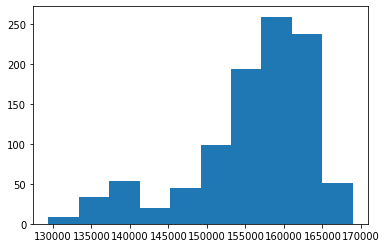

In [168]:
plt.hist(mask_size_list)

We can see that the biggest mask size is not much higher than the average.

# Examples

We give examples of use of the functions with the **canonical pipeline** versus the **(5,0,0) pipeline** (smoothing kernel FWHM=5mm, no motion regressors and no temporal derivatives of the HRF in the first-level analysis GLM).

In [20]:
Vect_vox_5240_5240_sample = voxel_concat_sample(5,24,0,5,24,0);

## qqplot_pval

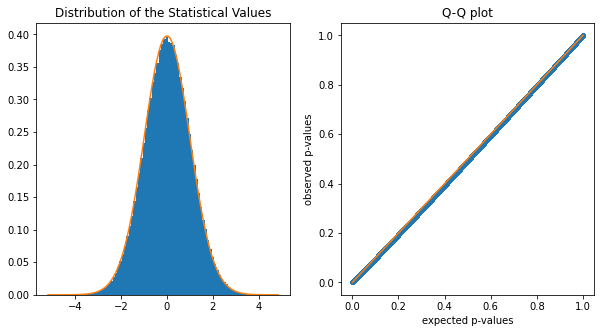

In [21]:
qqplot_pval(Vect_vox_5240_5240_sample,100)

The *qqplot_pval* function returns a couple of graphs: the first one shows the distribution of the input data (blue histogram) against the expected student law with df=98 distribution (orange line). The second one is a Q-Q plot, with the ordered p-values on the y-axis against the expected p-values (equal to $k/n$ with $k$ from $0$ to $n-1$) on the x-axis, as well as the y=x line.

In this example, it appears clearly that the p-values obtained are overall higher than expected, which is consistent with lower statistical values as we can observe on the first graph.

## Bland_Altman

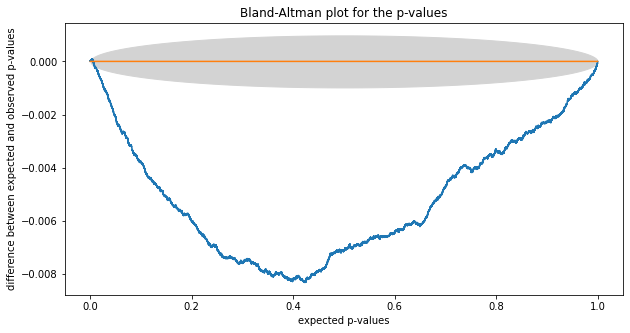

In [22]:
Bland_Altman(Vect_vox_5240_5240_sample)

The *Bland_Altman* function returns, for each expected p-value, the difference between the obtained and expected p-values, as well as the 95% confidence interval for the expected p-values. It allows us to have a better observation of the difference between the blue and orange plots on the Q-Q plot.

## Logarithmic Bland-Altman plots

Since we observed empirical false positive rates for an error rate of 1/1000 in this study, we are interested in observing the behavior of extreme p-values, which can hardly be observed on the simple Bland-Altman graph. For this reason, we created a couple of functions *Bland_Altman_log1* and *Bland_Altman_log2*.

The first function does the same as the simple Bland-Altman plot, but with the observed and theoretical p-values being replaced by their $log_{10}$ values, both on the x-axis and the y-axis.

The $log_{10}$ values of the 95% confidence interval around the expected p-values are also plotted for the 10000 lowest p-values.

ValueError: operands could not be broadcast together with shapes (10000,) (10989,) 

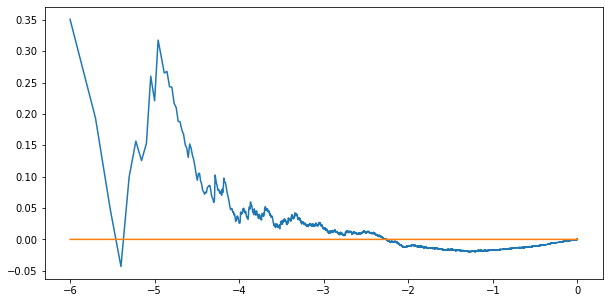

In [25]:
Bland_Altman_log1(Vect_vox_5240_5240_sample)

Since we observe the $log_{10}$ values of the expected p-values, which go from $1/1000000$ to $1$, on the x-axis, the lowest and highest values on the x-axis are $log_{10}(1/1000000)=-6$ and $log_{10}(1/1000000)=0$.

More specifically, for a given $k$, the $k$ lowest expected p-values on the x-axis are in the interval between $-6$ and $log_{10}(k/1000000)=log_{10}(k)-6$. Therefore, the first logarithmic graph gives us a better observation of the behavior of the p-values around 0.

(notably, since we plotted the confidence interval boundaries for the 10000 first p-values, it appears within the $[-6,-2]$ interval on the x-axis of the plot).

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


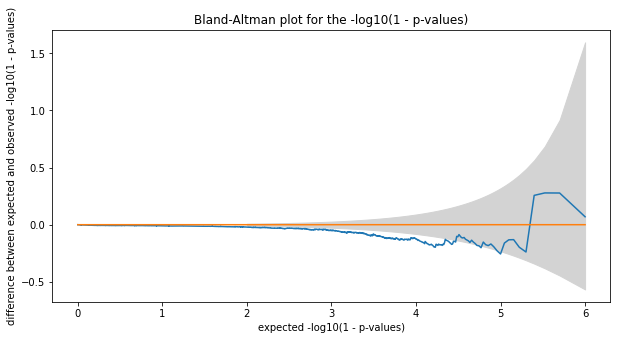

In [24]:
Bland_Altman_log2(Vect_vox_5240_5240_sample)

The second function does the same, but with $-log_{10}(1-p)$ instead of $log_{10}(p)$. Like the first logarithmic graph, it allows us to have a more precise observation of the p-values, but on the other extreme this time (p-values close to 1), and the boundaries of the confidence interval are plotted for the 10000 highest p-values instead of the lowest.

Similarly to the first logarithmic function, the $k$ highest expected p-values are contained in the interval $[6-log_{10}(k),6]$.

# Other Pairs of Pipelines

We performed group analyses with the first group being processed with the canonical pipeline and the second group with a pipeline among a group of twelve pipelines, which we will refer to as : (5,0,0) ; (5,0,1) ; (5,6,0) ; (5,6,1) *(canonical pipeline)* ; (5,24,0) ; (5,24,1) ; (8,0,0) ; (8,0,1) ; (8,6,0) ; (8,6,1) ; (8,24,0) ; (8,24,1).

## Vector definitions

In [28]:
Vect_vox_5240_5240_sample = voxel_concat_sample(5,24,0,5,24,0);

In [29]:
Vect_vox_5240_5241_sample = voxel_concat_sample(5,24,0,5,24,1);

In [30]:
Vect_vox_5240_800_sample = voxel_concat_sample(5,24,0,8,0,0);

In [31]:
Vect_vox_5240_860_sample = voxel_concat_sample(5,24,0,8,6,0);

In [32]:
Vect_vox_5240_8240_sample = voxel_concat_sample(5,24,0,8,24,0);

In [33]:
Vect_vox_560_560_sample = voxel_concat_sample(5,6,0,5,6,0);

In [34]:
Vect_vox_800_800_sample = voxel_concat_sample(8,0,0,8,0,0);

## Q-Q Plots for p-values & Bland-Altman Plots

### 5,24,0 vs 5,24,0

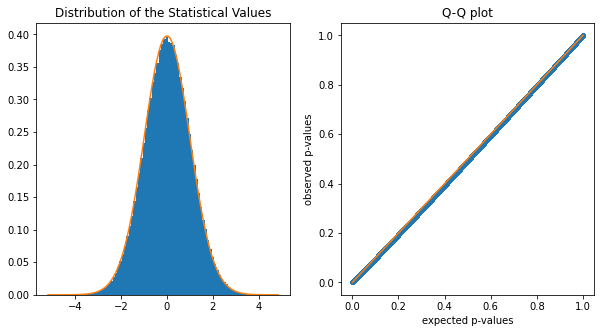

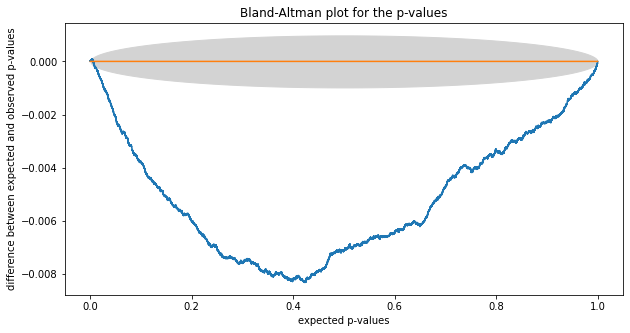

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


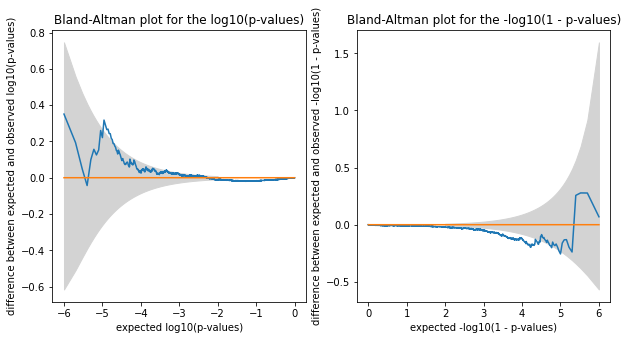

In [26]:
qqplot_pval(Vect_vox_5240_5240_sample,100)
Bland_Altman(Vect_vox_5240_5240_sample)
Bland_Altman_log(Vect_vox_5240_5240_sample)

### 5,24,0 vs 5,24,1

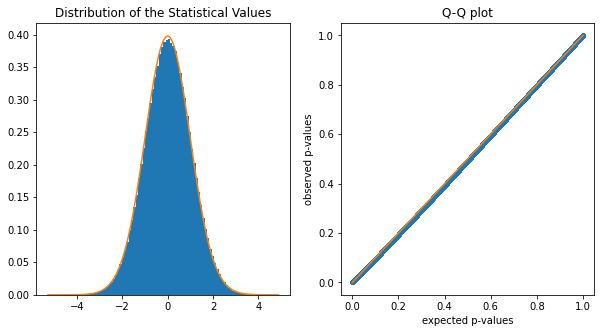

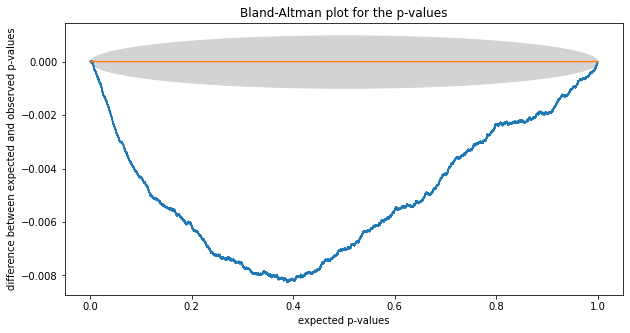

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


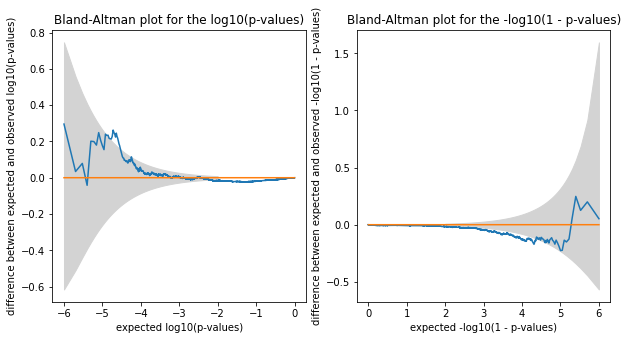

In [35]:
qqplot_pval(Vect_vox_5240_5241_sample,100)
Bland_Altman(Vect_vox_5240_5241_sample)
Bland_Altman_log(Vect_vox_5240_5241_sample)

### 5,24,0 vs 8,0,0

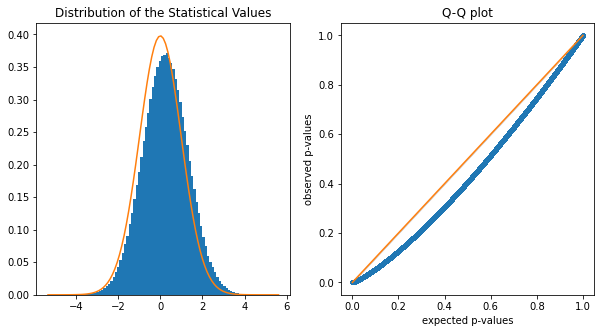

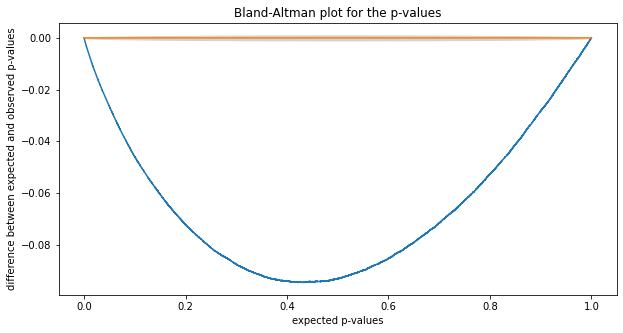

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


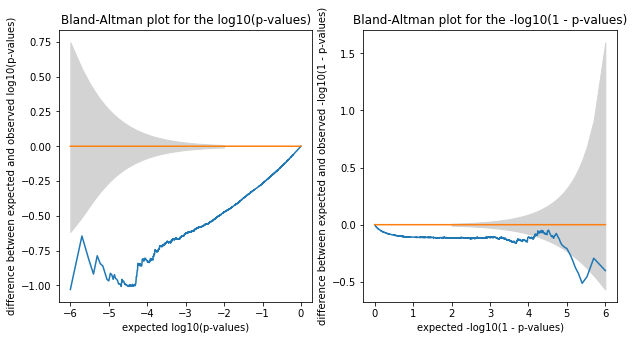

In [36]:
qqplot_pval(Vect_vox_5240_800_sample,100)
Bland_Altman(Vect_vox_5240_800_sample)
Bland_Altman_log(Vect_vox_5240_800_sample)

### 5,24,0 vs 8,6,0

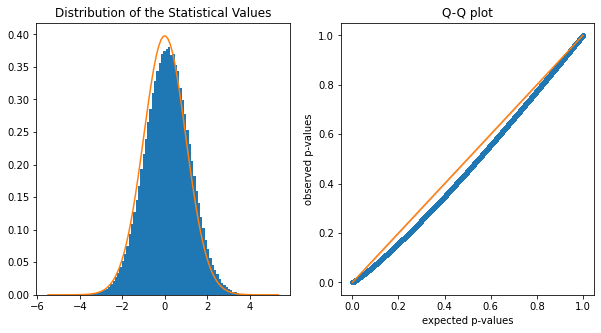

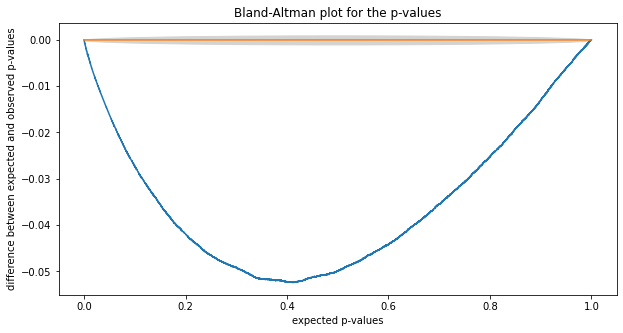

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


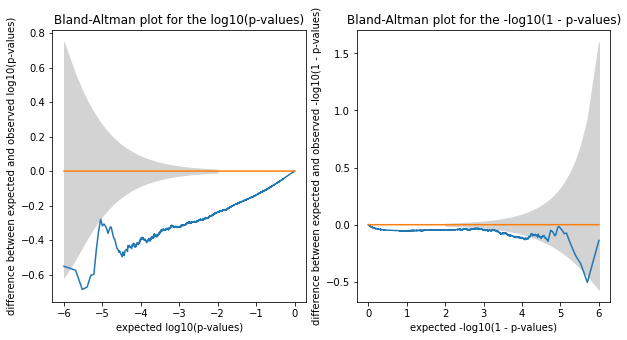

In [37]:
qqplot_pval(Vect_vox_5240_860_sample,100)
Bland_Altman(Vect_vox_5240_860_sample)
Bland_Altman_log(Vect_vox_5240_860_sample)

### 5,24,0 vs 8,24,0

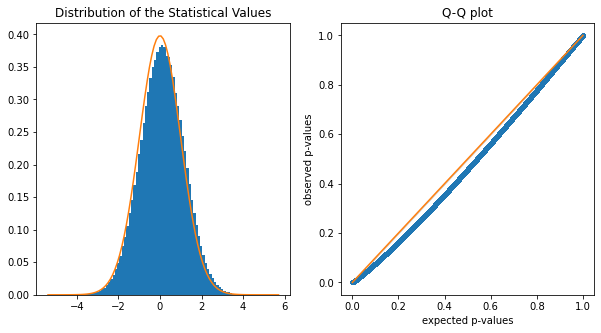

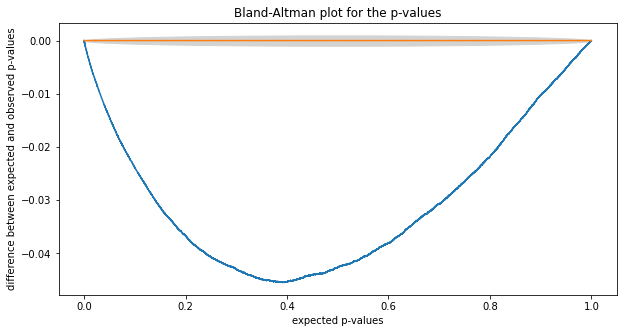

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


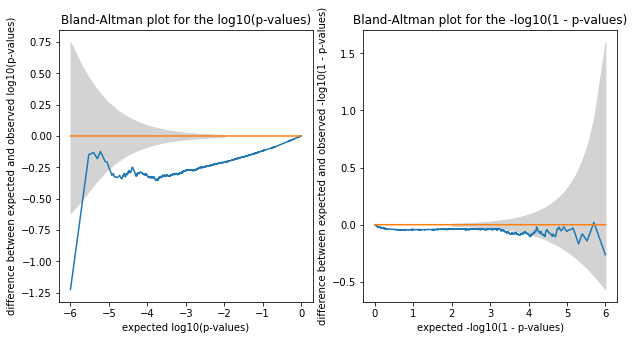

In [38]:
qqplot_pval(Vect_vox_5240_8240_sample,100)
Bland_Altman(Vect_vox_5240_8240_sample)
Bland_Altman_log(Vect_vox_5240_8240_sample)

### 5,6,0 vs 5,6,0

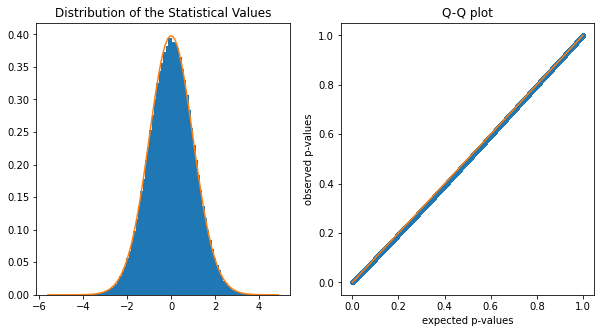

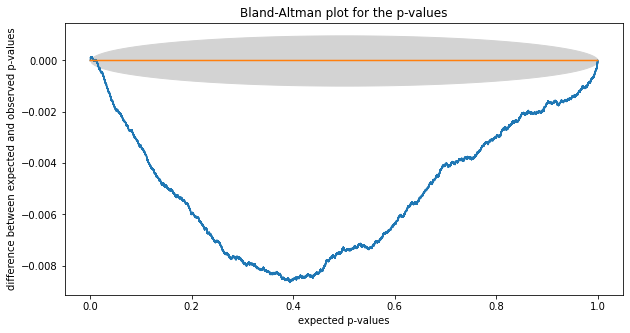

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


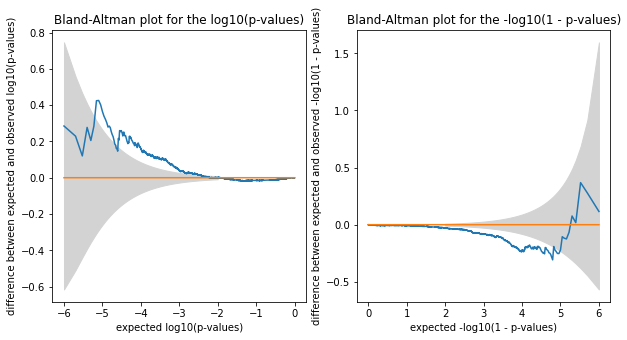

In [39]:
qqplot_pval(Vect_vox_560_560_sample,100)
Bland_Altman(Vect_vox_560_560_sample)
Bland_Altman_log(Vect_vox_560_560_sample)

### 8,0,0 vs 8,0,0

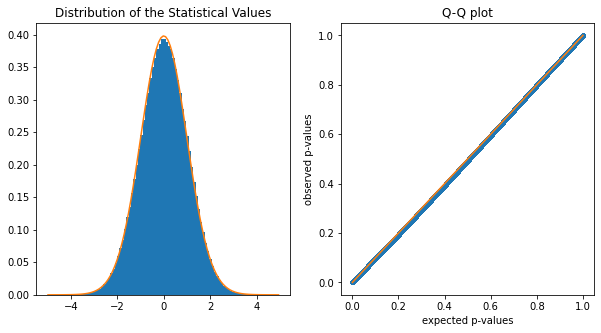

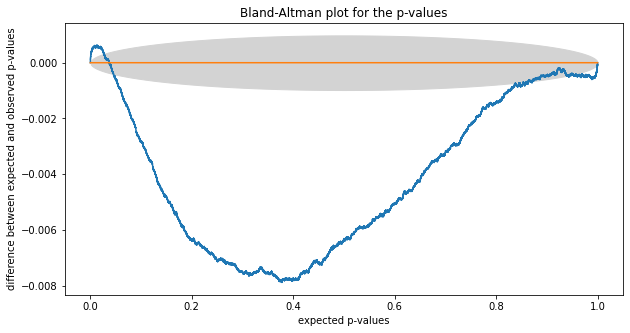

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


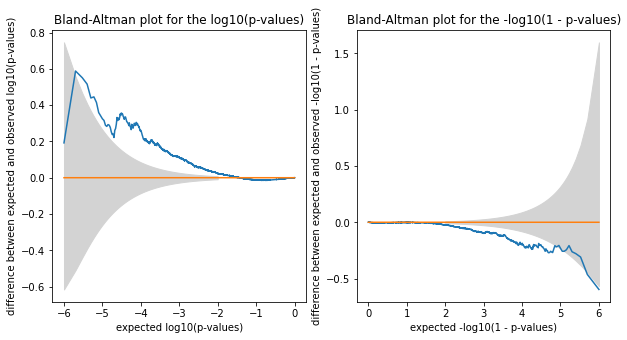

In [41]:
qqplot_pval(Vect_vox_800_800_sample,100)
Bland_Altman(Vect_vox_800_800_sample)
Bland_Altman_log(Vect_vox_800_800_sample)